In [72]:
%ls zippedData

 Volume in drive C has no label.
 Volume Serial Number is 62FC-0BEC

 Directory of C:\Users\pschu\Documents\Flatiron\projects\Microsoft_Studio_Analysis_Phase_1\zippedData

01/24/2023  10:11 AM    <DIR>          .
01/24/2023  10:11 AM    <DIR>          ..
01/24/2023  10:10 AM            53,544 bom.movie_gross.csv.gz
12/20/2021  02:31 PM       169,443,328 im.db
01/24/2023  10:10 AM        67,149,708 im.db.zip
01/24/2023  10:10 AM           498,202 rt.movie_info.tsv.gz
01/24/2023  10:10 AM         3,402,194 rt.reviews.tsv.gz
01/24/2023  10:10 AM           827,840 tmdb.movies.csv.gz
01/24/2023  10:10 AM           153,218 tn.movie_budgets.csv.gz
               7 File(s)    241,528,034 bytes
               2 Dir(s)  843,092,824,064 bytes free


In [73]:
import pandas as pd
import numpy as np
import sqlite3
import matplotlib.pyplot as plt
import seaborn as sns
sns.set(font_scale = 1)

%matplotlib inline

In [74]:
pd.set_option('display.float_format', lambda x: '%.5f' % x)

In [75]:
movies = pd.read_csv('zippedData\\tmdb.movies.csv.gz')

In [76]:
movie_budgets = pd.read_csv('zippedData\\tn.movie_budgets.csv.gz')

In [77]:
print(movies.columns, movie_budgets.columns)

Index(['Unnamed: 0', 'genre_ids', 'id', 'original_language', 'original_title',
       'popularity', 'release_date', 'title', 'vote_average', 'vote_count'],
      dtype='object') Index(['id', 'release_date', 'movie', 'production_budget', 'domestic_gross',
       'worldwide_gross'],
      dtype='object')


In [78]:
masterdf = movie_budgets.merge(movies, how='inner', left_on='movie', right_on='title', suffixes=('_budgets', '_movies'))

In [79]:
masterdf.shape

(2385, 16)

In [80]:
masterdf['movie'].duplicated()

0       False
1       False
2       False
3       False
4       False
        ...  
2380    False
2381    False
2382    False
2383    False
2384    False
Name: movie, Length: 2385, dtype: bool

In [81]:
conn = sqlite3.connect('zippedData/im.db')

In [82]:
basics_and_ratings = pd.read_sql("""
SELECT *
FROM movie_basics
LEFT JOIN movie_ratings
    ON movie_basics.movie_id = movie_ratings.movie_id
    """, conn )

In [83]:
new_masterdf = masterdf.merge(basics_and_ratings, how='inner', left_on='movie', right_on='primary_title', suffixes=('_master','_database')).drop_duplicates(subset='movie')

In [84]:
new_masterdf.shape

(1789, 25)

In [85]:
new_masterdf.columns

Index(['id_budgets', 'release_date_budgets', 'movie', 'production_budget',
       'domestic_gross', 'worldwide_gross', 'Unnamed: 0', 'genre_ids',
       'id_movies', 'original_language', 'original_title_master', 'popularity',
       'release_date_movies', 'title', 'vote_average', 'vote_count',
       'movie_id', 'primary_title', 'original_title_database', 'start_year',
       'runtime_minutes', 'genres', 'movie_id', 'averagerating', 'numvotes'],
      dtype='object')

In [86]:
new_masterdf.drop(['id_movies', 'Unnamed: 0', 'original_title_database', 'movie_id', 'primary_title', 'title'], axis=1, inplace=True)

In [87]:
new_masterdf.drop(['id_budgets'], axis=1, inplace=True)

In [88]:
new_masterdf.drop(['start_year', 'original_title_master'], axis=1, inplace=True)

In [89]:
new_masterdf['vote_count'].describe()

count    1789.00000
mean     1672.93907
std      2670.73022
min         1.00000
25%        79.00000
50%       620.00000
75%      2039.00000
max     22186.00000
Name: vote_count, dtype: float64

In [90]:
def remove_dollarsigncommas(data, column):
    data[column] = data[column].str.replace(',','')
    data[column] = data[column].str.replace('$','')
    return print('all done') ; print(data[column].head())

In [91]:
remove_dollarsigncommas(new_masterdf, 'production_budget')
remove_dollarsigncommas(new_masterdf, 'worldwide_gross')
remove_dollarsigncommas(new_masterdf, 'domestic_gross')

all done
all done
all done


In [92]:
new_masterdf.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 1789 entries, 0 to 4549
Data columns (total 15 columns):
 #   Column                Non-Null Count  Dtype  
---  ------                --------------  -----  
 0   release_date_budgets  1789 non-null   object 
 1   movie                 1789 non-null   object 
 2   production_budget     1789 non-null   object 
 3   domestic_gross        1789 non-null   object 
 4   worldwide_gross       1789 non-null   object 
 5   genre_ids             1789 non-null   object 
 6   original_language     1789 non-null   object 
 7   popularity            1789 non-null   float64
 8   release_date_movies   1789 non-null   object 
 9   vote_average          1789 non-null   float64
 10  vote_count            1789 non-null   int64  
 11  runtime_minutes       1739 non-null   float64
 12  genres                1778 non-null   object 
 13  averagerating         1714 non-null   float64
 14  numvotes              1714 non-null   float64
dtypes: float64(5), int64(

In [93]:
new_masterdf[['production_budget', 'domestic_gross', 'worldwide_gross']] = new_masterdf[['production_budget', 'domestic_gross', 'worldwide_gross']].applymap(lambda x: int(x))

In [94]:
new_masterdf['release_month'] = new_masterdf['release_date_movies'].map(lambda x: x[5:7])

In [95]:
new_masterdf

,release_date_budgets,movie,production_budget,domestic_gross,worldwide_gross,genre_ids,original_language,popularity,release_date_movies,vote_average,vote_count,runtime_minutes,genres,averagerating,numvotes,release_month
0,"Dec 18, 2009",Avatar,425000000,760507625,2776345279,"[28, 12, 14, 878]",en,26.52600,2009-12-18,7.40000,18676,93.00000,Horror,6.10000,43.00000,12
1,"May 20, 2011",Pirates of the Caribbean: On Stranger Tides,410600000,241063875,1045663875,"[12, 28, 14]",en,30.57900,2011-05-20,6.40000,8571,136.00000,"Action,Adventure,Fantasy",6.60000,447624.00000,05
2,"May 1, 2015",Avengers: Age of Ultron,330600000,459005868,1403013963,"[28, 12, 878]",en,44.38300,2015-05-01,7.30000,13457,141.00000,"Action,Adventure,Sci-Fi",7.30000,665594.00000,05
3,"Apr 27, 2018",Avengers: Infinity War,300000000,678815482,2048134200,"[12, 28, 14]",en,80.77300,2018-04-27,8.30000,13948,149.00000,"Action,Adventure,Sci-Fi",8.50000,670926.00000,04
4,"Nov 17, 2017",Justice League,300000000,229024295,655945209,"[28, 12, 14, 878]",en,34.95300,2017-11-17,6.20000,7510,120.00000,"Action,Adventure,Fantasy",6.50000,329135.00000,11
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
4541,"Sep 1, 2015",Exeter,25000,0,489792,"[53, 27]",en,5.93400,2015-03-26,4.70000,121,91.00000,"Horror,Mystery,Thriller",4.50000,5156.00000,03
4544,"Apr 21, 2015",Ten,25000,0,0,"[12, 27, 9648, 53]",en,1.57500,2014-03-28,5.40000,5,118.00000,Drama,5.50000,31.00000,03
4547,"Dec 31, 2014",Dry Spell,22000,0,0,"[35, 10749]",en,0.60000,2013-02-14,6.00000,1,90.00000,"Comedy,Romance",3.30000,120.00000,02
4548,"Jan 4, 2013",All Superheroes Must Die,20000,0,0,"[878, 53]",en,2.07800,2013-01-04,3.90000,19,78.00000,"Sci-Fi,Thriller",4.00000,1977.00000,01


In [96]:
tmdb_movie_genreIDs = {'genres':[{'id':28,'name':'Action'},
    {'id':12,'name':'Adventure'},
    {'id':16,'name':'Animation'},
    {'id':35,'name':'Comedy'},
    {'id':80,'name':'Crime'},
    {'id':99,'name':'Documentary'},
    {'id':18,'name':'Drama'},
    {'id':10751,'name':'Family'},
    {'id':14,'name':'Fantasy'},
    {'id':36,'name':'History'},
    {'id':27,'name':'Horror'},
    {'id':10402,'name':'Music'},
    {'id':9648,'name':'Mystery'},
    {'id':10749,'name':'Romance'},
    {'id':878,'name':'Science Fiction'},
    {'id':10770,'name':'TV Movie'},
    {'id':53,'name':'Thriller'},
    {'id':10752,'name':'War'},
    {'id':37,'name':'Western'}]}

In [97]:
new_masterdf['genre_ids'] = new_masterdf['genre_ids'].str.replace('28', 'Action')
new_masterdf['genre_ids'] = new_masterdf['genre_ids'].str.replace('12', 'Adventure')
new_masterdf['genre_ids'] = new_masterdf['genre_ids'].str.replace('16', 'Animation')
new_masterdf['genre_ids'] = new_masterdf['genre_ids'].str.replace('35', 'Comedy')
new_masterdf['genre_ids'] = new_masterdf['genre_ids'].str.replace('80', 'Crime')
new_masterdf['genre_ids'] = new_masterdf['genre_ids'].str.replace('99', 'Documentary')
new_masterdf['genre_ids'] = new_masterdf['genre_ids'].str.replace('18', 'Drama')
new_masterdf['genre_ids'] = new_masterdf['genre_ids'].str.replace('10751', 'Family')
new_masterdf['genre_ids'] = new_masterdf['genre_ids'].str.replace('14', 'Fantasy')
new_masterdf['genre_ids'] = new_masterdf['genre_ids'].str.replace('36', 'History')
new_masterdf['genre_ids'] = new_masterdf['genre_ids'].str.replace('27', 'Horror')
new_masterdf['genre_ids'] = new_masterdf['genre_ids'].str.replace('10402', 'Music')
new_masterdf['genre_ids'] = new_masterdf['genre_ids'].str.replace('9648', 'Mystery')
new_masterdf['genre_ids'] = new_masterdf['genre_ids'].str.replace('10749', 'Romance')
new_masterdf['genre_ids'] = new_masterdf['genre_ids'].str.replace('878', 'Science Fiction')
new_masterdf['genre_ids'] = new_masterdf['genre_ids'].str.replace('10770', 'TV Movie')
new_masterdf['genre_ids'] = new_masterdf['genre_ids'].str.replace('53', 'Thriller')
new_masterdf['genre_ids'] = new_masterdf['genre_ids'].str.replace('10752', 'War')
new_masterdf['genre_ids'] = new_masterdf['genre_ids'].str.replace('37', 'Western')

In [98]:
new_masterdf['genre_ids'] = new_masterdf['genre_ids'].map(lambda x: x.lstrip('[').rstrip(']').split(','))

In [99]:
new_masterdf.reset_index(inplace=True)

In [100]:
final_df = new_masterdf.join(pd.DataFrame(new_masterdf.genre_ids.values.tolist()).add_prefix('genre_'), how='left', lsuffix='_votes')
final_df.drop('index', axis=1, inplace=True)
final_df.isna().sum()/len(final_df)

release_date_budgets   0.00000
movie                  0.00000
production_budget      0.00000
domestic_gross         0.00000
worldwide_gross        0.00000
genre_ids              0.00000
original_language      0.00000
popularity             0.00000
release_date_movies    0.00000
vote_average           0.00000
vote_count             0.00000
runtime_minutes        0.02795
genres                 0.00615
averagerating          0.04192
numvotes               0.04192
release_month          0.00000
genre_0                0.00000
genre_1                0.23812
genre_2                0.55115
genre_3                0.84572
genre_4                0.96534
genre_5                0.99329
genre_6                0.99944
dtype: float64

In [101]:
final_df.drop(['genre_6','genre_5','genre_4','genre_3', 'genre_2' ], axis=1, inplace=True)
final_df['original_language'].value_counts()

en    1719
fr      17
es       9
hi       8
zh       6
ru       4
de       3
ja       2
pl       2
ko       2
te       1
he       1
hu       1
sv       1
et       1
tl       1
nl       1
ur       1
xx       1
id       1
lt       1
da       1
tr       1
el       1
fa       1
ar       1
th       1
Name: original_language, dtype: int64

In [102]:
final_df.drop('original_language', axis=1, inplace=True)


In [103]:
final_df['worldwide_gross'].describe()

count         1789.00000
mean     122286157.08999
std      227256447.56779
min              0.00000
25%        3541565.00000
50%       37831658.00000
75%      126931325.00000
max     2776345279.00000
Name: worldwide_gross, dtype: float64

In [104]:
final_df = final_df[final_df['worldwide_gross'] > 3541565]
final_df

,release_date_budgets,movie,production_budget,domestic_gross,worldwide_gross,genre_ids,popularity,release_date_movies,vote_average,vote_count,runtime_minutes,genres,averagerating,numvotes,release_month,genre_0,genre_1
0,"Dec 18, 2009",Avatar,425000000,760507625,2776345279,"[Action, Adventure, Fantasy, Science Fiction]",26.52600,2009-12-18,7.40000,18676,93.00000,Horror,6.10000,43.00000,12,Action,Adventure
1,"May 20, 2011",Pirates of the Caribbean: On Stranger Tides,410600000,241063875,1045663875,"[Adventure, Action, Fantasy]",30.57900,2011-05-20,6.40000,8571,136.00000,"Action,Adventure,Fantasy",6.60000,447624.00000,05,Adventure,Action
2,"May 1, 2015",Avengers: Age of Ultron,330600000,459005868,1403013963,"[Action, Adventure, Science Fiction]",44.38300,2015-05-01,7.30000,13457,141.00000,"Action,Adventure,Sci-Fi",7.30000,665594.00000,05,Action,Adventure
3,"Apr 27, 2018",Avengers: Infinity War,300000000,678815482,2048134200,"[Adventure, Action, Fantasy]",80.77300,2018-04-27,8.30000,13948,149.00000,"Action,Adventure,Sci-Fi",8.50000,670926.00000,04,Adventure,Action
4,"Nov 17, 2017",Justice League,300000000,229024295,655945209,"[Action, Adventure, Fantasy, Science Fiction]",34.95300,2017-11-17,6.20000,7510,120.00000,"Action,Adventure,Fantasy",6.50000,329135.00000,11,Action,Adventure
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1722,"May 1, 1981",Graduation Day,250000,23894000,23894000,[],0.60000,2015-01-01,5.00000,1,75.00000,Thriller,5.00000,52.00000,01,,None
1723,"Apr 28, 2017",Sleight,250000,3930990,3934450,"[Drama, Thriller, Action, Science Fiction]",5.66400,2017-04-28,5.30000,367,89.00000,"Action,Drama,Sci-Fi",5.90000,7074.00000,04,Drama,Thriller
1724,"Oct 28, 2011",Like Crazy,250000,3395391,3728400,"[Drama, Romance]",10.09100,2011-10-28,6.50000,638,86.00000,"Drama,Romance",6.70000,55841.00000,10,Drama,Romance
1725,"Sep 11, 1998",Cube,250000,489220,8969065,[],0.84000,2014-05-02,2.00000,1,113.00000,"Biography,Documentary",nan,nan,05,,None


In [105]:
final_df.drop('genres', axis=1, inplace=True)

In [106]:
final_df['release_year'] = final_df['release_date_budgets'].map(lambda x: int(x[-4:]))

In [107]:
final_df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 1341 entries, 0 to 1753
Data columns (total 17 columns):
 #   Column                Non-Null Count  Dtype  
---  ------                --------------  -----  
 0   release_date_budgets  1341 non-null   object 
 1   movie                 1341 non-null   object 
 2   production_budget     1341 non-null   int64  
 3   domestic_gross        1341 non-null   int64  
 4   worldwide_gross       1341 non-null   int64  
 5   genre_ids             1341 non-null   object 
 6   popularity            1341 non-null   float64
 7   release_date_movies   1341 non-null   object 
 8   vote_average          1341 non-null   float64
 9   vote_count            1341 non-null   int64  
 10  runtime_minutes       1308 non-null   float64
 11  averagerating         1290 non-null   float64
 12  numvotes              1290 non-null   float64
 13  release_month         1341 non-null   object 
 14  genre_0               1341 non-null   object 
 15  genre_1              

In [108]:
final_df = final_df[final_df['release_year'] >= 2009]
final_df.shape

(1237, 17)

In [109]:
final_df.drop(['release_date_budgets', 'vote_count', 'vote_average', 'popularity'], axis=1, inplace=True)
final_df

C:\Users\pschu\anaconda3\envs\learn-env\lib\site-packages\pandas\core\frame.py:4163: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  return super().drop(


,movie,production_budget,domestic_gross,worldwide_gross,genre_ids,release_date_movies,runtime_minutes,averagerating,numvotes,release_month,genre_0,genre_1,release_year
0,Avatar,425000000,760507625,2776345279,"[Action, Adventure, Fantasy, Science Fiction]",2009-12-18,93.00000,6.10000,43.00000,12,Action,Adventure,2009
1,Pirates of the Caribbean: On Stranger Tides,410600000,241063875,1045663875,"[Adventure, Action, Fantasy]",2011-05-20,136.00000,6.60000,447624.00000,05,Adventure,Action,2011
2,Avengers: Age of Ultron,330600000,459005868,1403013963,"[Action, Adventure, Science Fiction]",2015-05-01,141.00000,7.30000,665594.00000,05,Action,Adventure,2015
3,Avengers: Infinity War,300000000,678815482,2048134200,"[Adventure, Action, Fantasy]",2018-04-27,149.00000,8.50000,670926.00000,04,Adventure,Action,2018
4,Justice League,300000000,229024295,655945209,"[Action, Adventure, Fantasy, Science Fiction]",2017-11-17,120.00000,6.50000,329135.00000,11,Action,Adventure,2017
...,...,...,...,...,...,...,...,...,...,...,...,...,...
1673,Safety Not Guaranteed,750000,4010957,4422318,"[Comedy, Romance, Science Fiction, Drama]",2012-06-08,86.00000,7.00000,111907.00000,06,Comedy,Romance,2012
1689,Monsters,500000,237301,5639730,"[Drama, Thriller, Science Fiction]",2010-10-29,94.00000,6.40000,84332.00000,10,Drama,Thriller,2010
1723,Sleight,250000,3930990,3934450,"[Drama, Thriller, Action, Science Fiction]",2017-04-28,89.00000,5.90000,7074.00000,04,Drama,Thriller,2017
1724,Like Crazy,250000,3395391,3728400,"[Drama, Romance]",2011-10-28,86.00000,6.70000,55841.00000,10,Drama,Romance,2011


In [110]:
final_df['net_profits'] = final_df['worldwide_gross'] - final_df['production_budget']
final_df['profit_to_budget_ratio'] = final_df['net_profits'] / final_df['production_budget']
final_df

<ipython-input-110-06905da70f3b>:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  final_df['net_profits'] = final_df['worldwide_gross'] - final_df['production_budget']
<ipython-input-110-06905da70f3b>:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  final_df['profit_to_budget_ratio'] = final_df['net_profits'] / final_df['production_budget']


,movie,production_budget,domestic_gross,worldwide_gross,genre_ids,release_date_movies,runtime_minutes,averagerating,numvotes,release_month,genre_0,genre_1,release_year,net_profits,profit_to_budget_ratio
0,Avatar,425000000,760507625,2776345279,"[Action, Adventure, Fantasy, Science Fiction]",2009-12-18,93.00000,6.10000,43.00000,12,Action,Adventure,2009,2351345279,5.53258
1,Pirates of the Caribbean: On Stranger Tides,410600000,241063875,1045663875,"[Adventure, Action, Fantasy]",2011-05-20,136.00000,6.60000,447624.00000,05,Adventure,Action,2011,635063875,1.54667
2,Avengers: Age of Ultron,330600000,459005868,1403013963,"[Action, Adventure, Science Fiction]",2015-05-01,141.00000,7.30000,665594.00000,05,Action,Adventure,2015,1072413963,3.24384
3,Avengers: Infinity War,300000000,678815482,2048134200,"[Adventure, Action, Fantasy]",2018-04-27,149.00000,8.50000,670926.00000,04,Adventure,Action,2018,1748134200,5.82711
4,Justice League,300000000,229024295,655945209,"[Action, Adventure, Fantasy, Science Fiction]",2017-11-17,120.00000,6.50000,329135.00000,11,Action,Adventure,2017,355945209,1.18648
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1673,Safety Not Guaranteed,750000,4010957,4422318,"[Comedy, Romance, Science Fiction, Drama]",2012-06-08,86.00000,7.00000,111907.00000,06,Comedy,Romance,2012,3672318,4.89642
1689,Monsters,500000,237301,5639730,"[Drama, Thriller, Science Fiction]",2010-10-29,94.00000,6.40000,84332.00000,10,Drama,Thriller,2010,5139730,10.27946
1723,Sleight,250000,3930990,3934450,"[Drama, Thriller, Action, Science Fiction]",2017-04-28,89.00000,5.90000,7074.00000,04,Drama,Thriller,2017,3684450,14.73780
1724,Like Crazy,250000,3395391,3728400,"[Drama, Romance]",2011-10-28,86.00000,6.70000,55841.00000,10,Drama,Romance,2011,3478400,13.91360


In [111]:
type(((final_df.groupby('release_month').mean()['worldwide_gross'] - final_df.groupby('release_month').mean()['production_budget']).values.tolist())[0])

float

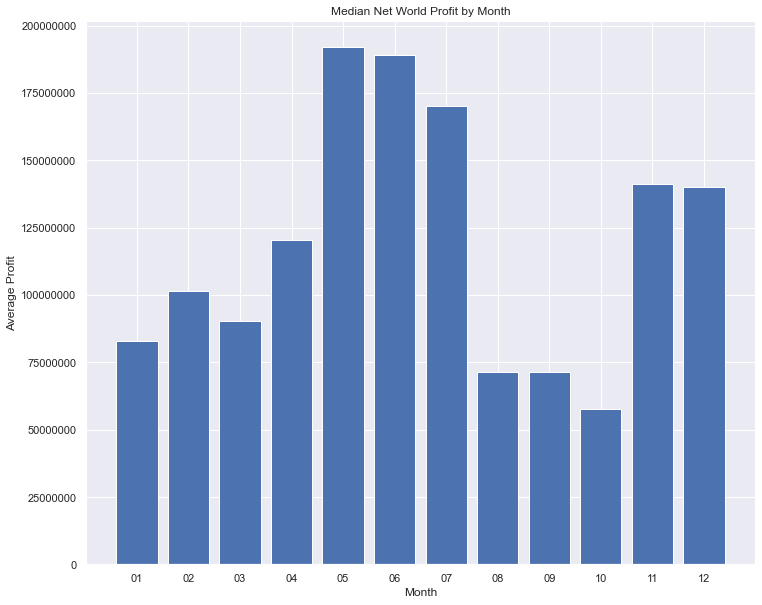

In [112]:
fig, ax = plt.subplots(figsize=(12,10))
ax.set_title('Median Net World Profit by Month')
ax.bar(
     (final_df.groupby('release_month').mean()['worldwide_gross'] - final_df.groupby('release_month').mean()['production_budget']).index.tolist()
     ,
    ((final_df.groupby('release_month').mean()['worldwide_gross'] - final_df.groupby('release_month').mean()['production_budget']).values.tolist()))

ax.set_ylabel('Average Profit')
ax.set_xlabel('Month')
ax.set_xticks(range(13))
ax.ticklabel_format(style='plain', axis='y')
plt.show()

In [113]:
((final_df.groupby('release_month').mean()['worldwide_gross']/final_df.groupby('release_month').mean()['production_budget']).values.tolist())

[3.044280936624454,
 3.2094504735310316,
 2.605354119094145,
 3.945806518764368,
 3.3036166996012977,
 3.7016624574823247,
 3.578940377301812,
 2.7143620551661223,
 2.932273242185688,
 2.813473779676614,
 3.3012968292128217,
 3.556057416922219]

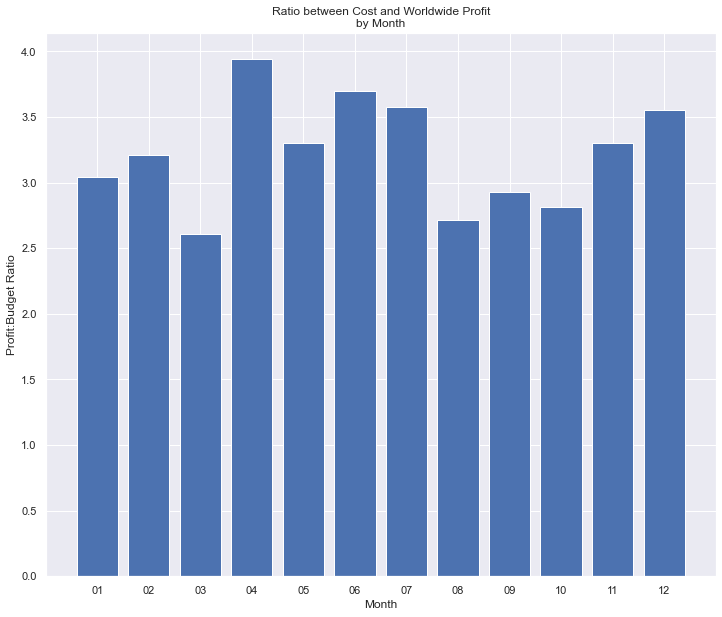

In [114]:
fig, ax = plt.subplots(figsize=(12,10))
ax.set_title('Ratio between Cost and Worldwide Profit\nby Month')
ax.bar(
     
     ((final_df.groupby('release_month').mean()['worldwide_gross']/final_df.groupby('release_month').mean()['production_budget']).index.tolist()),
     ((final_df.groupby('release_month').mean()['worldwide_gross']/final_df.groupby('release_month').mean()['production_budget']).values.tolist()))

ax.set_ylabel('Profit:Budget Ratio')
ax.set_xlabel('Month')
ax.set_xticks(range(13))
plt.show()

In [115]:
sortgenres = final_df.groupby('genre_0').mean()
sortgenres

,production_budget,domestic_gross,worldwide_gross,runtime_minutes,averagerating,numvotes,release_year,net_profits,profit_to_budget_ratio
genre_0,,,,,,,,,
,37172727.27273,26873164.36364,56500812.63636,92.22222,5.43333,17716.11111,2014.00000,19328085.36364,1.74710
Action,91031174.08907,106616755.58704,299244405.85425,113.57377,6.41488,209335.03719,2014.10121,208213231.76518,2.17285
Adventure,111232926.82927,119280182.60976,344678206.71951,111.25610,6.48519,187860.82716,2014.02439,233445279.89024,1.97983
Animation,98651162.79070,131848289.79070,377674689.60465,94.12195,6.74634,136591.26829,2013.32558,279023526.81395,2.74876
Comedy,29789508.92857,49588632.42857,92567399.15625,102.34081,6.21461,87893.64384,2013.37946,62777890.22768,2.77722
Crime,35000000.00000,41550726.87755,91364595.55102,114.79167,6.69583,153572.04167,2013.91837,56364595.55102,1.86699
Documentary,31000000.00000,46372167.66667,92772670.50000,96.45455,6.67273,37878.63636,2014.58333,61772670.50000,2.41857
Drama,25807229.03780,37867225.43299,81746155.68385,113.23860,6.79296,112865.14789,2013.70790,55938926.64605,3.33636
Family,58441176.47059,88665326.52941,252428021.35294,93.70588,6.34118,74974.82353,2013.76471,193986844.88235,2.73178


Text(0.5, 0, 'Genre')

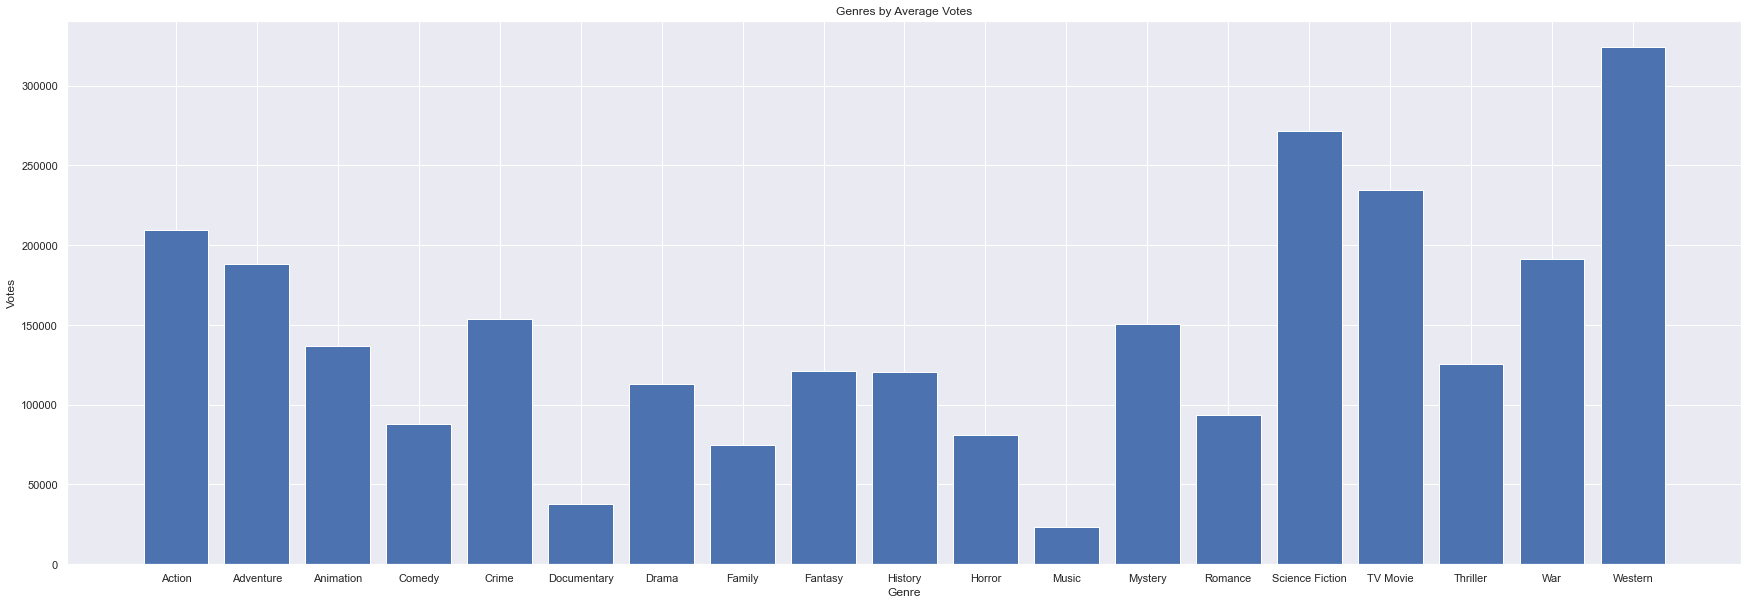

In [116]:
fig, ax = plt.subplots(figsize= (30, 10))
ax.set_title('Genres by Average Votes')
ax.bar( sortgenres.iloc[1:].index, sortgenres['numvotes'].iloc[1:]) #filtering out the blank genre row from the column
ax.set_ylabel('Votes')
ax.set_xlabel('Genre')

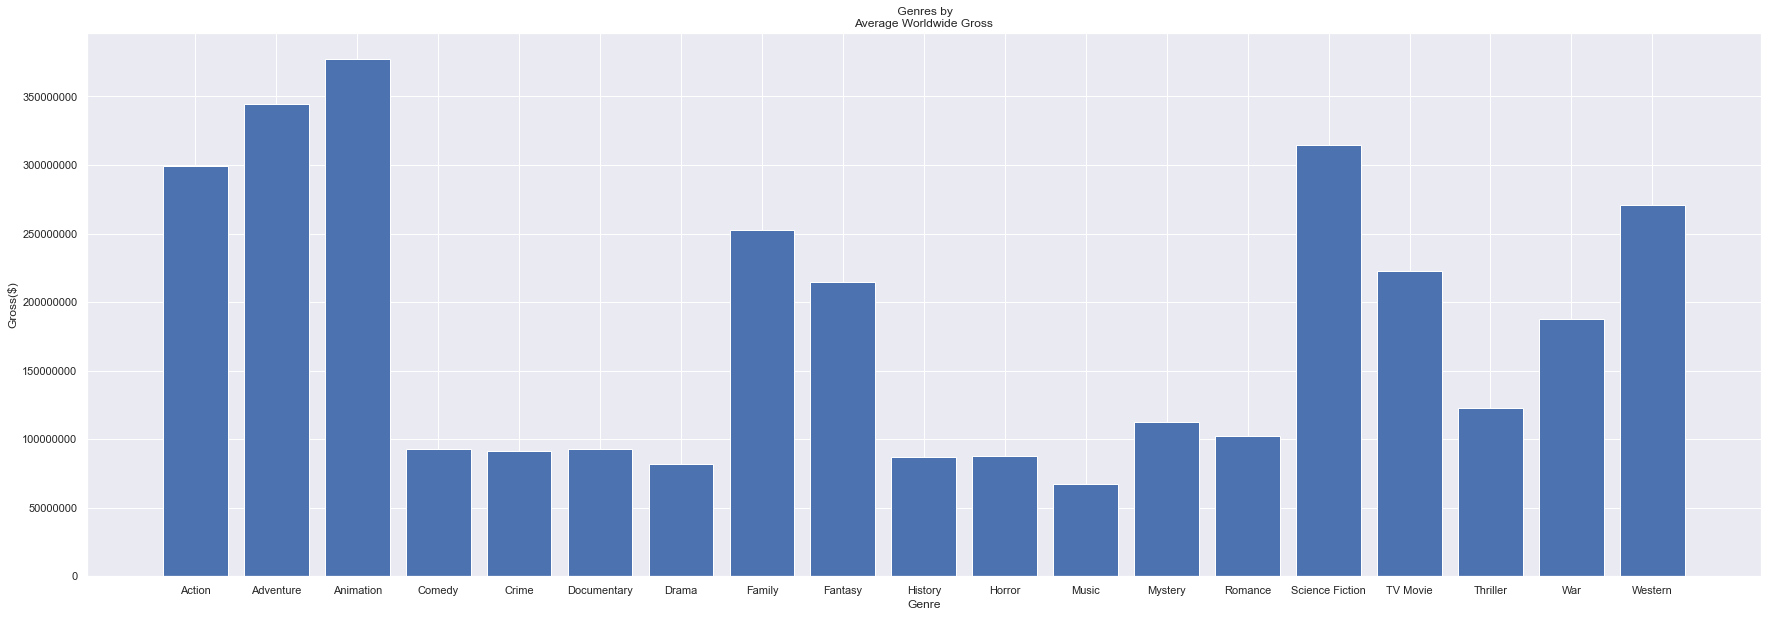

In [117]:
fig, ax = plt.subplots(figsize= (30, 10))
ax.set_title(' Genres by\nAverage Worldwide Gross')
ax.bar( sortgenres.iloc[1:].index, sortgenres['worldwide_gross'].iloc[1:]) #filtering out the blank genre row from the column
ax.set_ylabel('Gross($)')
ax.set_xlabel('Genre')
ax.ticklabel_format(style='plain', axis='y')
plt.show()

In [118]:
(sortgenres['worldwide_gross'] -sortgenres['production_budget'])[1:]

genre_0
Action            208213231.76518
Adventure         233445279.89024
Animation         279023526.81395
Comedy             62777890.22768
Crime              56364595.55102
Documentary        61772670.50000
Drama              55938926.64605
Family            193986844.88235
Fantasy           130135155.31034
History            63840292.70000
Horror             69725769.34722
Music              21256103.75000
Mystery            82201018.91667
Romance            73470449.43333
Science Fiction   228583483.79310
TV Movie          172383055.00000
Thriller           85705277.63492
War               119321465.66667
Western           195077936.50000
dtype: float64

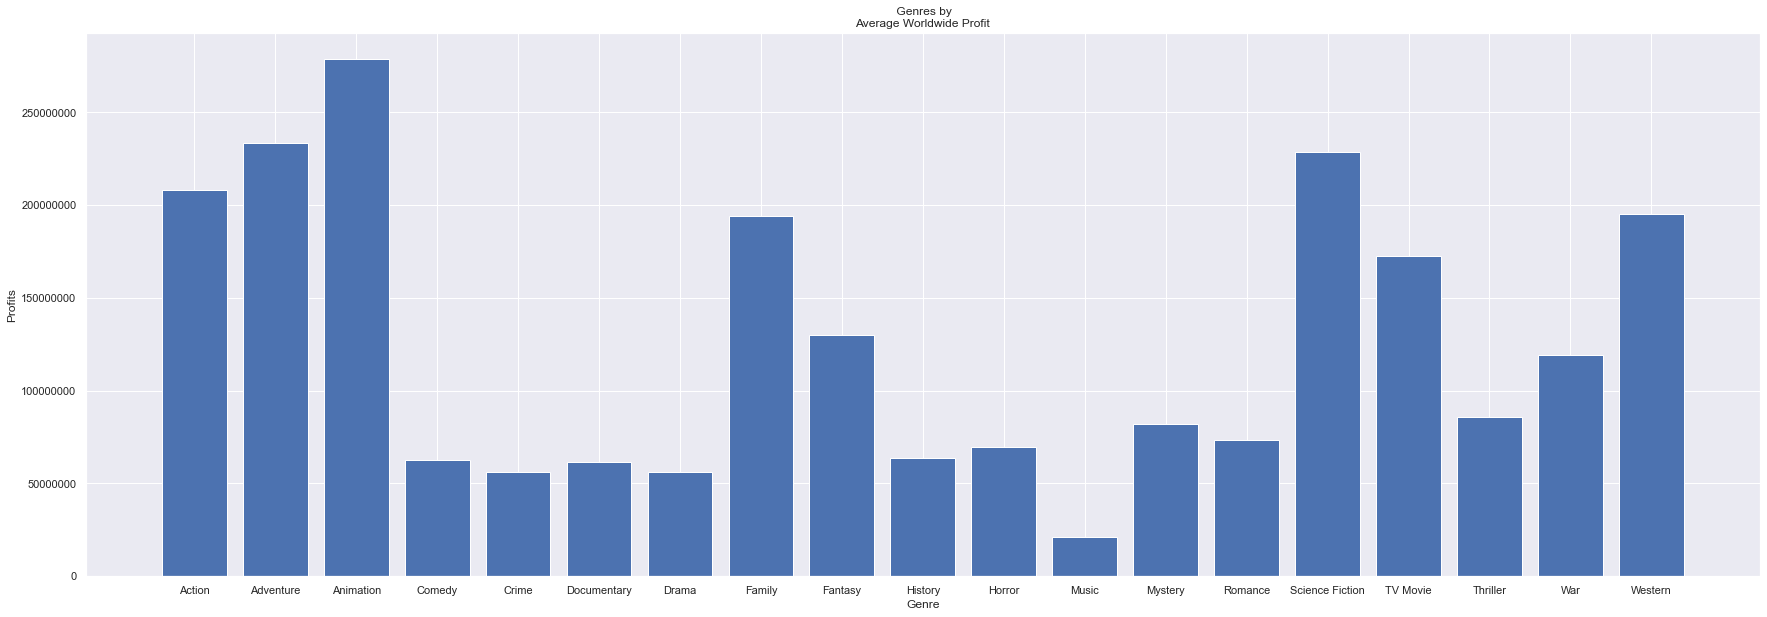

In [119]:
fig, ax = plt.subplots(figsize= (30, 10))
ax.set_title(' Genres by\nAverage Worldwide Profit')
ax.bar( sortgenres.iloc[1:].index, (sortgenres['worldwide_gross'] -sortgenres['production_budget'])[1:]) #filtering out the blank genre row from the column
ax.set_ylabel('Profits')
ax.set_xlabel('Genre')
ax.ticklabel_format(style='plain', axis='y')
plt.show()

*c* argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with *x* & *y*.  Please use the *color* keyword-argument or provide a 2-D array with a single row if you intend to specify the same RGB or RGBA value for all points.


<AxesSubplot:xlabel='runtime_minutes', ylabel='averagerating'>

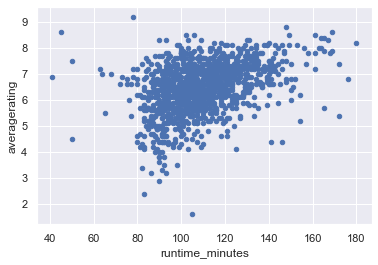

In [120]:
final_df.plot.scatter('runtime_minutes', 'averagerating')

*c* argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with *x* & *y*.  Please use the *color* keyword-argument or provide a 2-D array with a single row if you intend to specify the same RGB or RGBA value for all points.


<AxesSubplot:xlabel='runtime_minutes', ylabel='numvotes'>

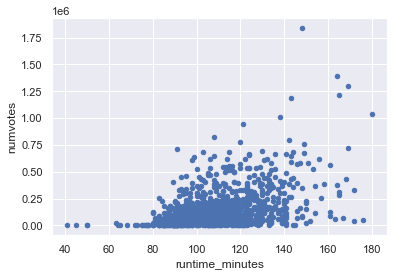

In [121]:
final_df.plot.scatter('runtime_minutes', 'numvotes')

<ipython-input-122-38ac25302a9d>:13: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax1.axes.set_xticklabels(genreinfo)


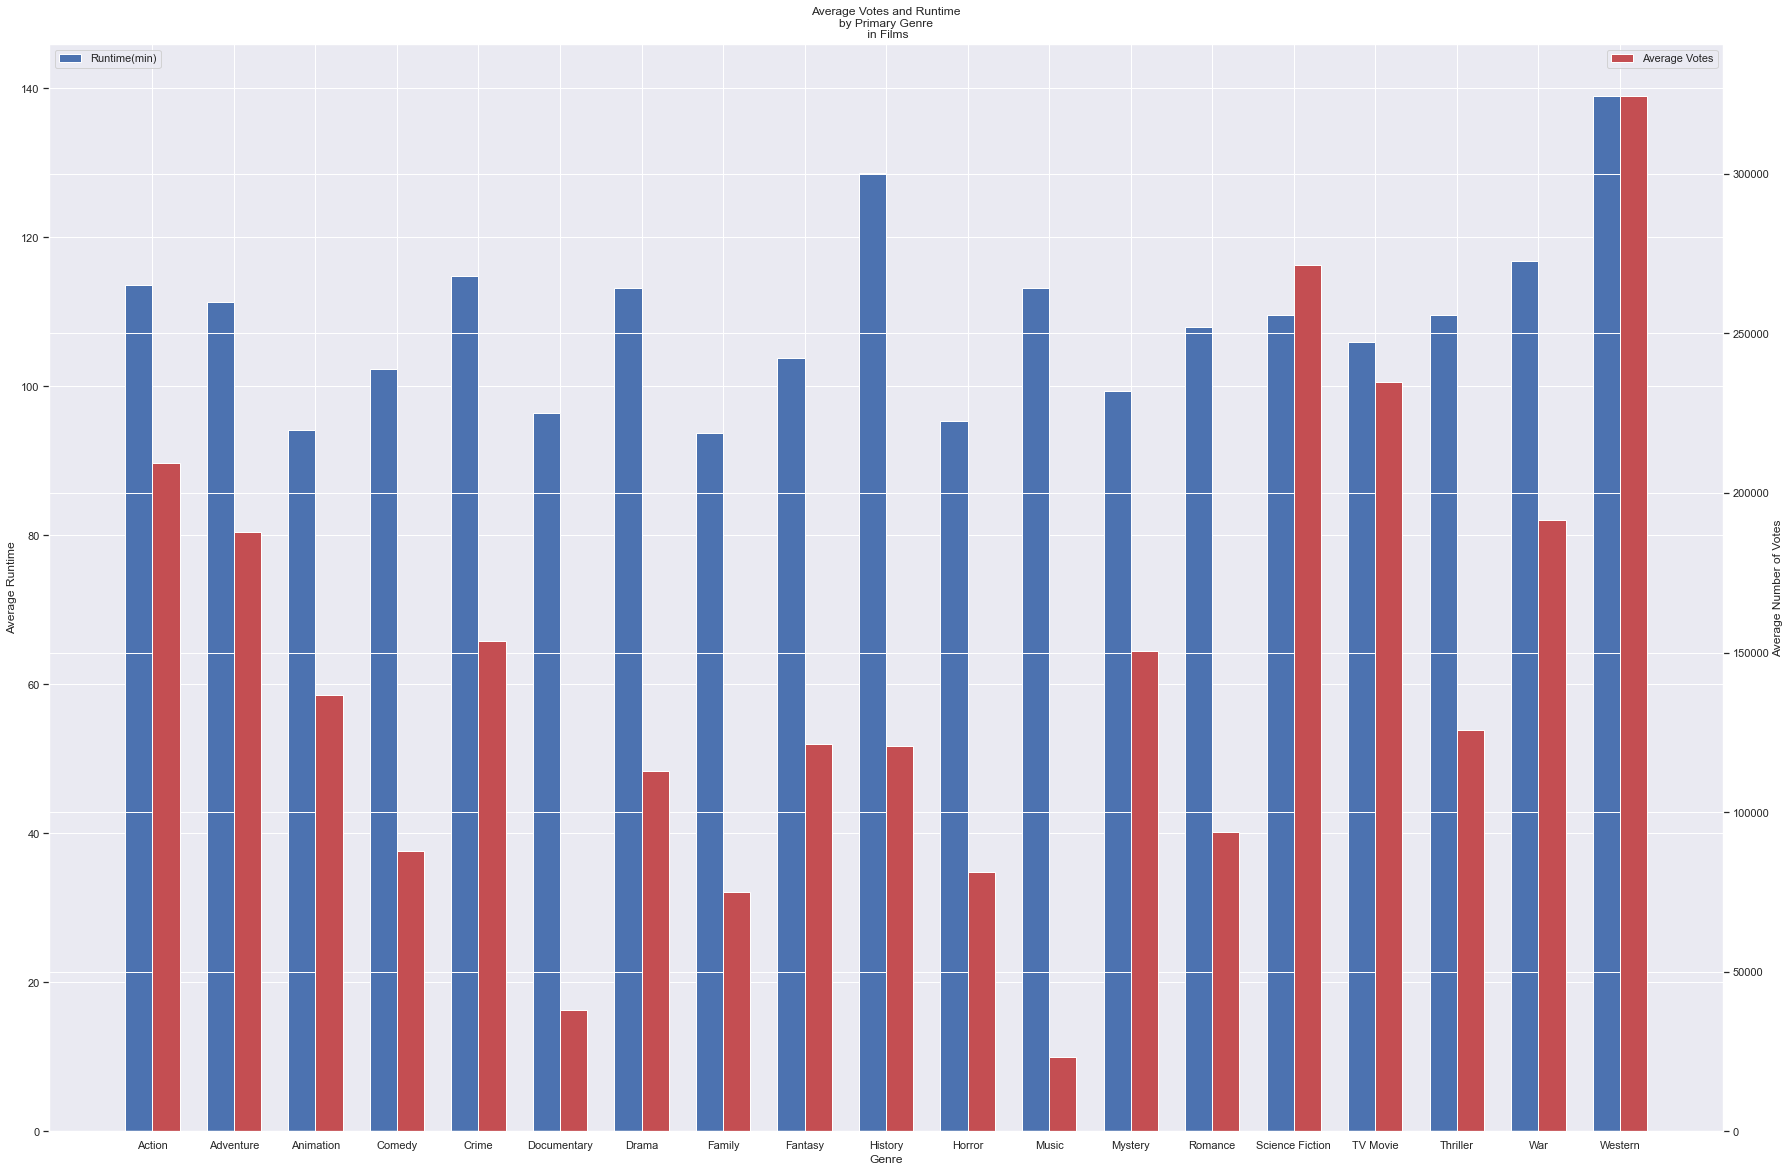

In [122]:
runtimeinfo = sortgenres['runtime_minutes'][1:]
numvoteinfo = sortgenres['numvotes'][1:]
indices = range(len(sortgenres[1:]))
genreinfo = sortgenres[1:].index
# Calculate optimal width
width = np.min(np.diff(indices))/3.

fig, ax1 = plt.subplots(figsize=(30,20))
ax1.bar(indices-width/2.,runtimeinfo,width,color='b', label='Runtime(min)')
ax2 = ax1.twinx()
ax2.bar(indices+width/2.,numvoteinfo,width,color='r', label='Average Votes')
# tiks = ax.get_xticks()
ax1.axes.set_xticklabels(genreinfo)
ax1.set_xlabel('Genre')
ax1.set_ylabel('Average Runtime')
ax2.set_ylabel('Average Number of Votes')
ax1.set_xticks(indices)
ax1.set_title('Average Votes and Runtime\nby Primary Genre\n in Films')
ax1.legend(loc=2)
ax2.legend(loc=0)
plt.show()

<ipython-input-123-ce1987628918>:13: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax1.axes.set_xticklabels(genreinfo)


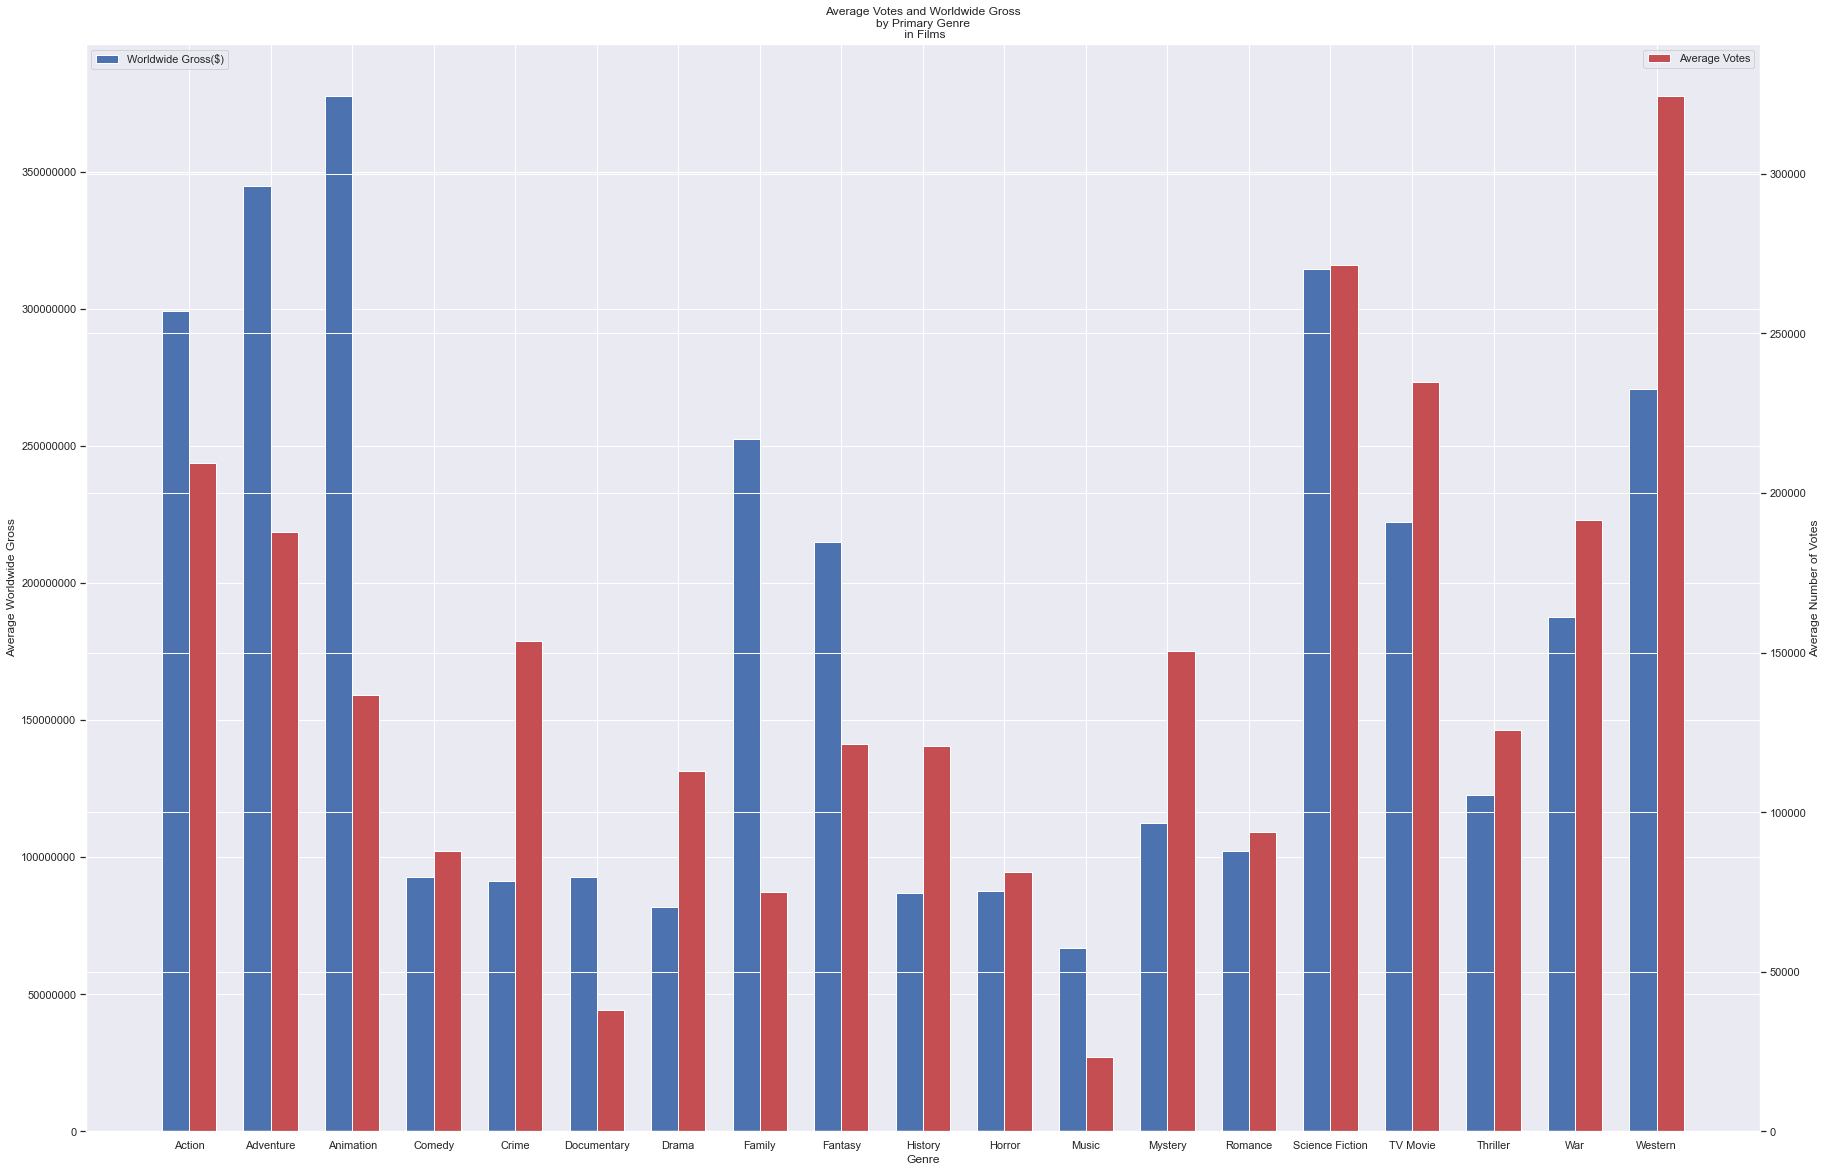

In [123]:
runtimeinfo = sortgenres['worldwide_gross'][1:]
numvoteinfo = sortgenres['numvotes'][1:]
indices = range(len(sortgenres[1:]))
genreinfo = sortgenres[1:].index
# Calculate optimal width
width = np.min(np.diff(indices))/3.

fig, ax1 = plt.subplots(figsize=(30,20))
ax1.bar(indices-width/2.,runtimeinfo,width,color='b', label='Worldwide Gross($)')
ax2 = ax1.twinx()
ax2.bar(indices+width/2.,numvoteinfo,width,color='r', label='Average Votes')
# tiks = ax.get_xticks()
ax1.axes.set_xticklabels(genreinfo)
ax1.set_xlabel('Genre')
ax1.set_ylabel('Average Worldwide Gross')
ax2.set_ylabel('Average Number of Votes')
ax1.set_xticks(indices)
ax1.set_title('Average Votes and Worldwide Gross\nby Primary Genre\n in Films')
ax1.legend(loc=2)
ax2.legend(loc=0)
ax1.ticklabel_format(style='plain', axis='y')
ax2.ticklabel_format(style='plain', axis='y')
plt.show()

<ipython-input-124-ce1987628918>:13: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax1.axes.set_xticklabels(genreinfo)


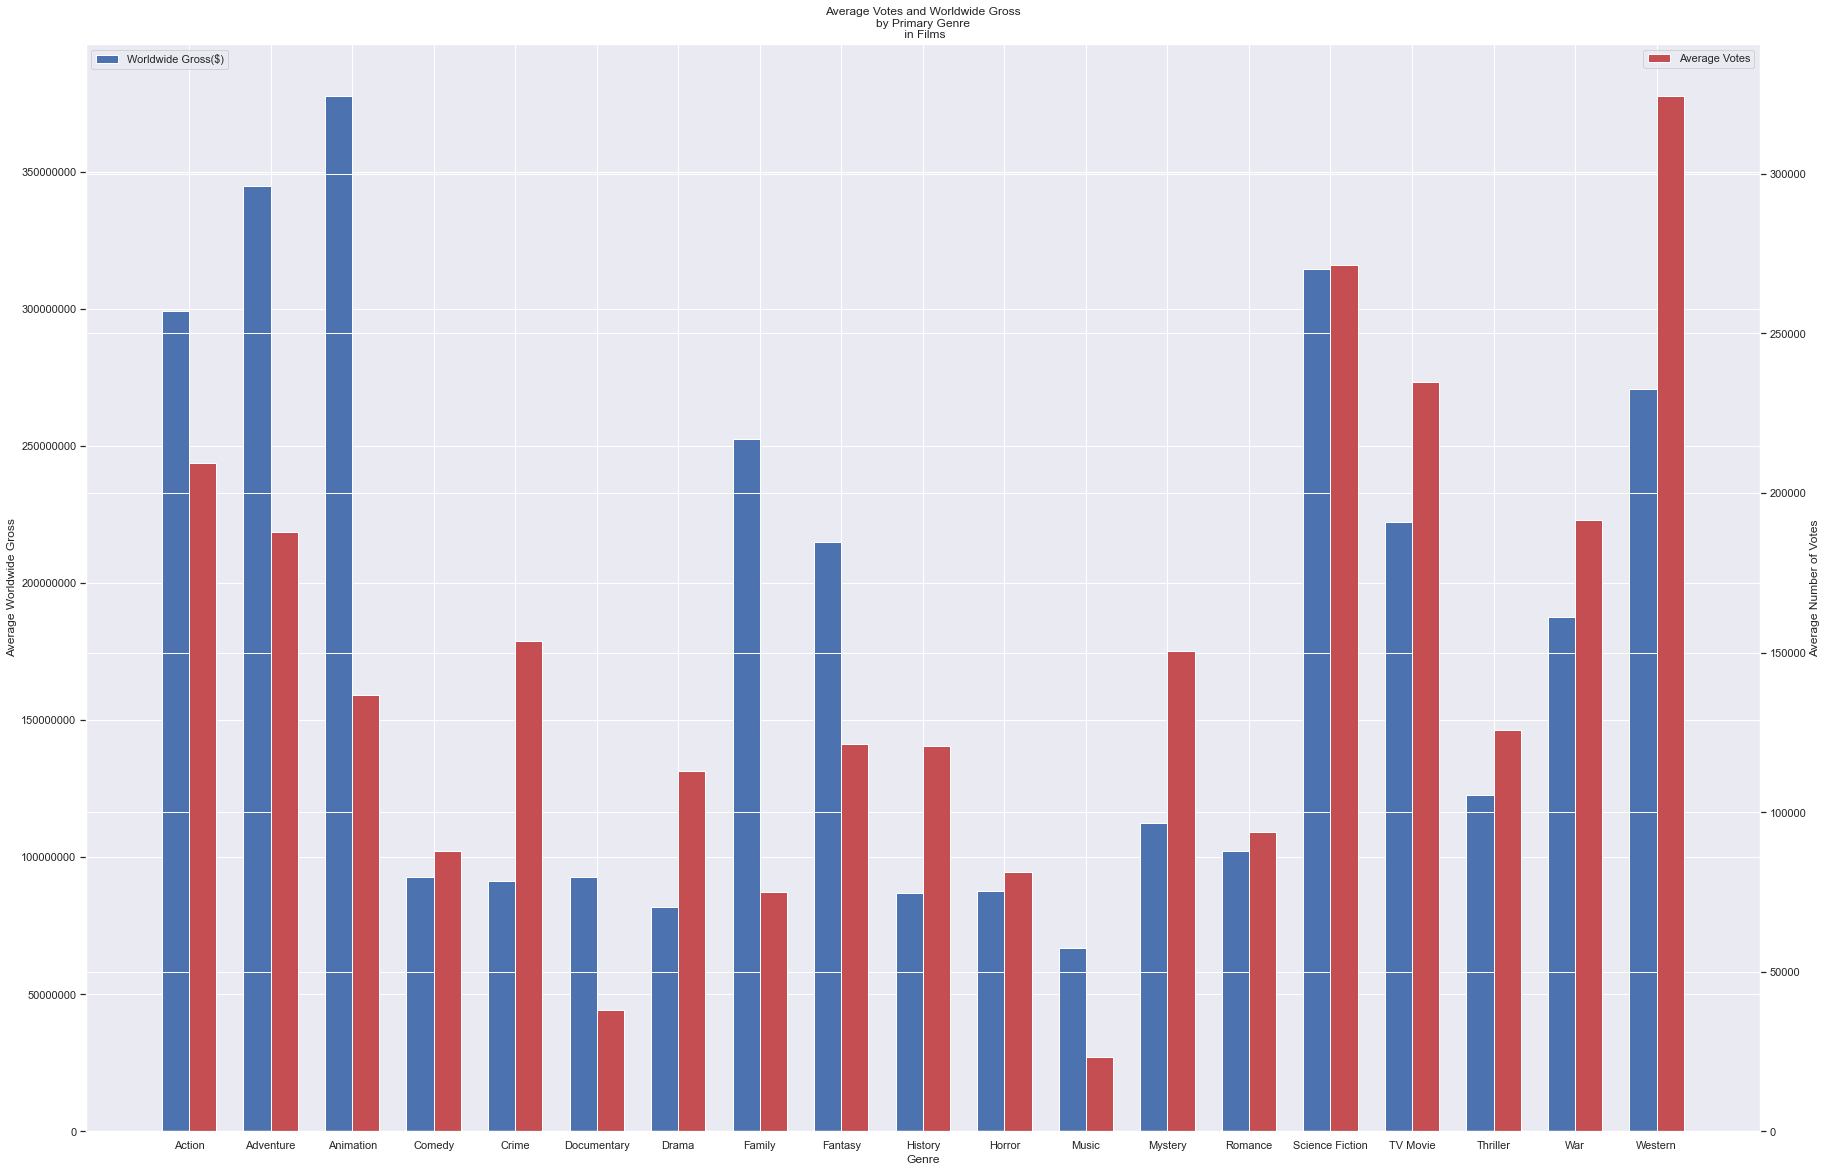

In [124]:
runtimeinfo = sortgenres['worldwide_gross'][1:]
numvoteinfo = sortgenres['numvotes'][1:]
indices = range(len(sortgenres[1:]))
genreinfo = sortgenres[1:].index
# Calculate optimal width
width = np.min(np.diff(indices))/3.

fig, ax1 = plt.subplots(figsize=(30,20))
ax1.bar(indices-width/2.,runtimeinfo,width,color='b', label='Worldwide Gross($)')
ax2 = ax1.twinx()
ax2.bar(indices+width/2.,numvoteinfo,width,color='r', label='Average Votes')
# tiks = ax.get_xticks()
ax1.axes.set_xticklabels(genreinfo)
ax1.set_xlabel('Genre')
ax1.set_ylabel('Average Worldwide Gross')
ax2.set_ylabel('Average Number of Votes')
ax1.set_xticks(indices)
ax1.set_title('Average Votes and Worldwide Gross\nby Primary Genre\n in Films')
ax1.legend(loc=2)
ax2.legend(loc=0)
ax1.ticklabel_format(style='plain', axis='y')
ax2.ticklabel_format(style='plain', axis='y')
plt.show()

In [125]:
final_df

,movie,production_budget,domestic_gross,worldwide_gross,genre_ids,release_date_movies,runtime_minutes,averagerating,numvotes,release_month,genre_0,genre_1,release_year,net_profits,profit_to_budget_ratio
0,Avatar,425000000,760507625,2776345279,"[Action, Adventure, Fantasy, Science Fiction]",2009-12-18,93.00000,6.10000,43.00000,12,Action,Adventure,2009,2351345279,5.53258
1,Pirates of the Caribbean: On Stranger Tides,410600000,241063875,1045663875,"[Adventure, Action, Fantasy]",2011-05-20,136.00000,6.60000,447624.00000,05,Adventure,Action,2011,635063875,1.54667
2,Avengers: Age of Ultron,330600000,459005868,1403013963,"[Action, Adventure, Science Fiction]",2015-05-01,141.00000,7.30000,665594.00000,05,Action,Adventure,2015,1072413963,3.24384
3,Avengers: Infinity War,300000000,678815482,2048134200,"[Adventure, Action, Fantasy]",2018-04-27,149.00000,8.50000,670926.00000,04,Adventure,Action,2018,1748134200,5.82711
4,Justice League,300000000,229024295,655945209,"[Action, Adventure, Fantasy, Science Fiction]",2017-11-17,120.00000,6.50000,329135.00000,11,Action,Adventure,2017,355945209,1.18648
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1673,Safety Not Guaranteed,750000,4010957,4422318,"[Comedy, Romance, Science Fiction, Drama]",2012-06-08,86.00000,7.00000,111907.00000,06,Comedy,Romance,2012,3672318,4.89642
1689,Monsters,500000,237301,5639730,"[Drama, Thriller, Science Fiction]",2010-10-29,94.00000,6.40000,84332.00000,10,Drama,Thriller,2010,5139730,10.27946
1723,Sleight,250000,3930990,3934450,"[Drama, Thriller, Action, Science Fiction]",2017-04-28,89.00000,5.90000,7074.00000,04,Drama,Thriller,2017,3684450,14.73780
1724,Like Crazy,250000,3395391,3728400,"[Drama, Romance]",2011-10-28,86.00000,6.70000,55841.00000,10,Drama,Romance,2011,3478400,13.91360


In [126]:
sortgenres.sort_values('worldwide_gross', ascending=False).head()

,production_budget,domestic_gross,worldwide_gross,runtime_minutes,averagerating,numvotes,release_year,net_profits,profit_to_budget_ratio
genre_0,,,,,,,,,
Animation,98651162.79070,131848289.79070,377674689.60465,94.12195,6.74634,136591.26829,2013.32558,279023526.81395,2.74876
Adventure,111232926.82927,119280182.60976,344678206.71951,111.25610,6.48519,187860.82716,2014.02439,233445279.89024,1.97983
Science Fiction,85903448.27586,120010796.00000,314486932.06897,109.58621,6.60690,271370.20690,2013.93103,228583483.79310,3.53109
Action,91031174.08907,106616755.58704,299244405.85425,113.57377,6.41488,209335.03719,2014.10121,208213231.76518,2.17285
Western,75500000.00000,93033941.50000,270577936.50000,139.00000,7.30000,324458.50000,2014.50000,195077936.50000,1.23064


<ipython-input-127-ffadb5c0fe3e>:14: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax1.axes.set_xticklabels(genreinfo)


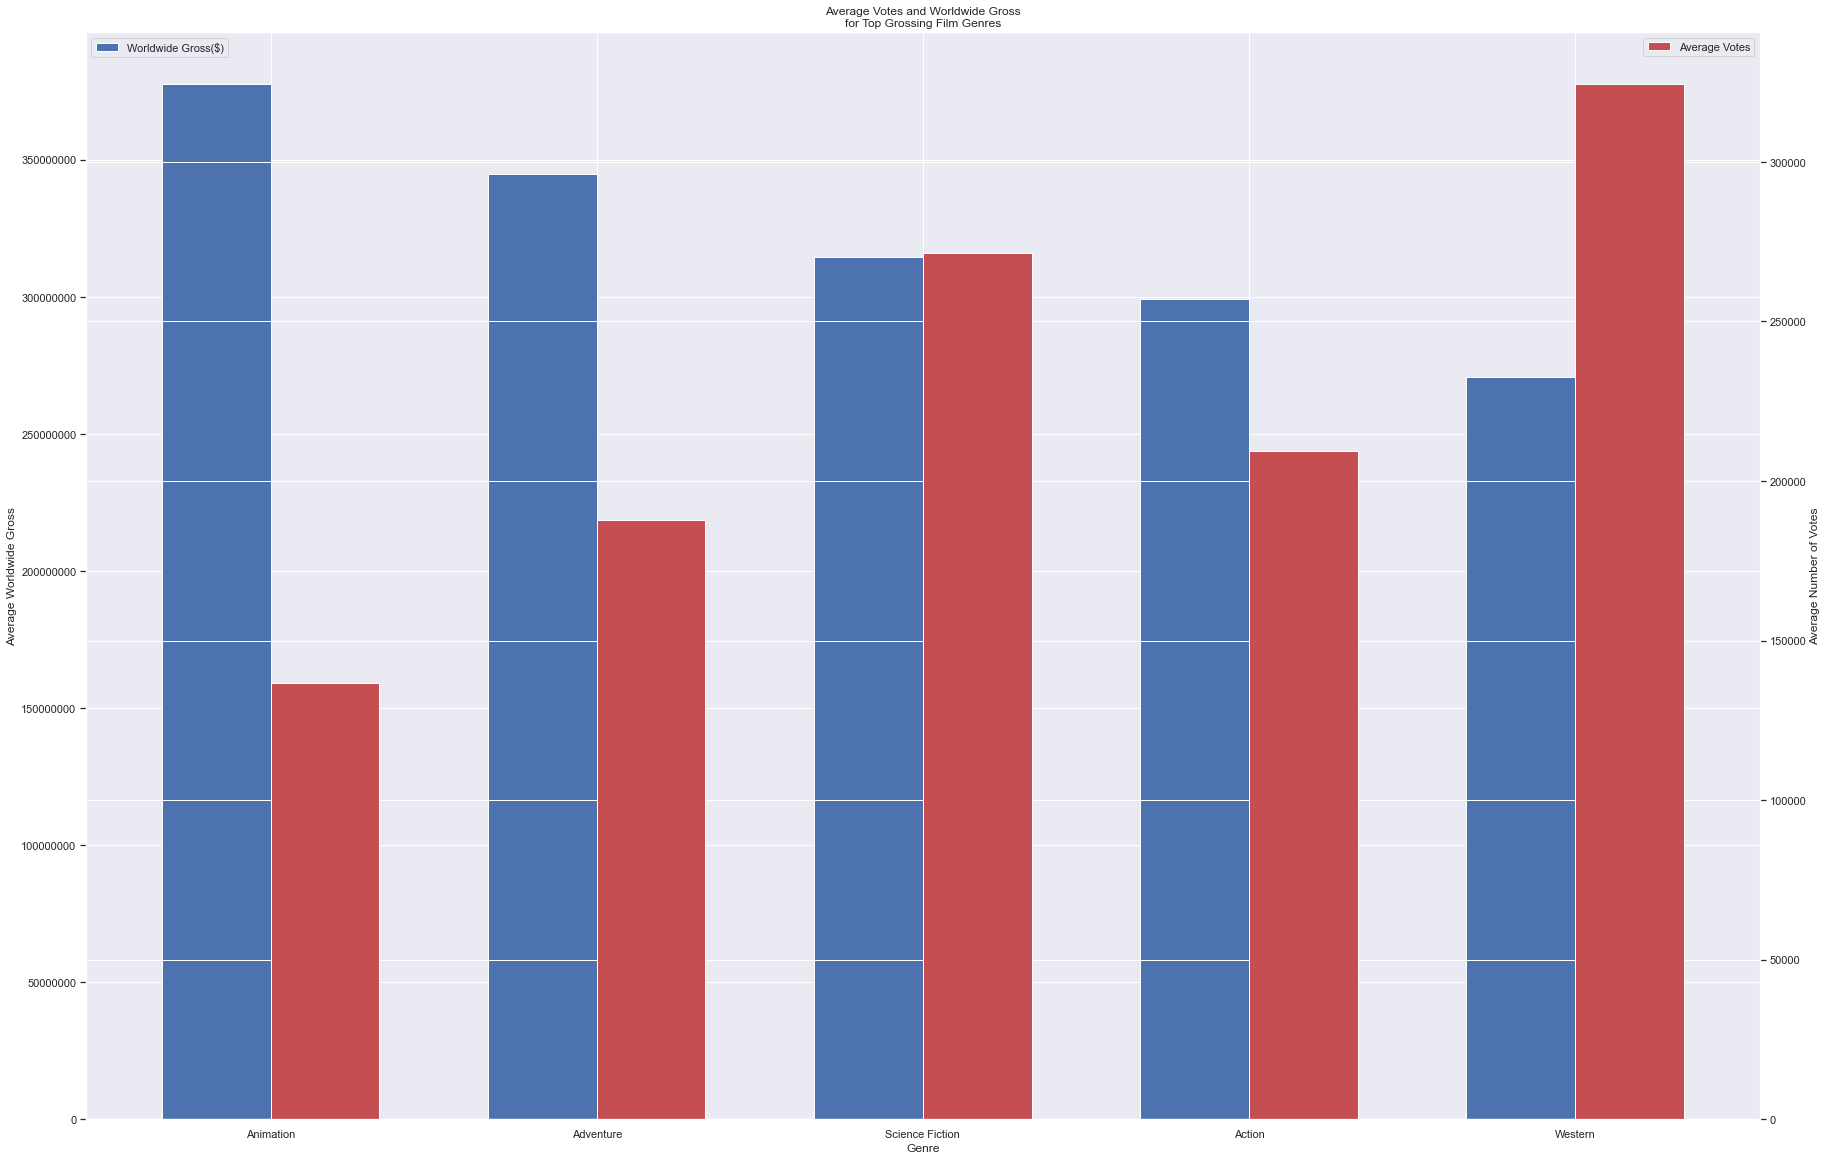

In [127]:
topfivegenresbywwgross = sortgenres.sort_values('worldwide_gross', ascending=False).head() #filtering to 
runtimeinfo = topfivegenresbywwgross['worldwide_gross']
numvoteinfo = topfivegenresbywwgross['numvotes']
indices = range(len(topfivegenresbywwgross))
genreinfo = topfivegenresbywwgross.index
# Calculate optimal width
width = np.min(np.diff(indices))/3.

fig, ax1 = plt.subplots(figsize=(30,20))
ax1.bar(indices-width/2.,runtimeinfo,width,color='b', label='Worldwide Gross($)')
ax2 = ax1.twinx()
ax2.bar(indices+width/2.,numvoteinfo,width,color='r', label='Average Votes')
# tiks = ax.get_xticks()
ax1.axes.set_xticklabels(genreinfo)
ax1.set_xlabel('Genre')
ax1.set_ylabel('Average Worldwide Gross')
ax2.set_ylabel('Average Number of Votes')
ax1.set_xticks(indices)
ax1.set_title('Average Votes and Worldwide Gross\nfor Top Grossing Film Genres')
ax1.legend(loc=2)
ax2.legend(loc=0)
ax1.ticklabel_format(style='plain', axis='y')
ax2.ticklabel_format(style='plain', axis='y')
plt.show()

In [128]:
topfivegenresbywwgross = sortgenres.sort_values('worldwide_gross', ascending=False).head()


<ipython-input-129-11fb6ffccecc>:15: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax1.axes.set_xticklabels(genreinfo)


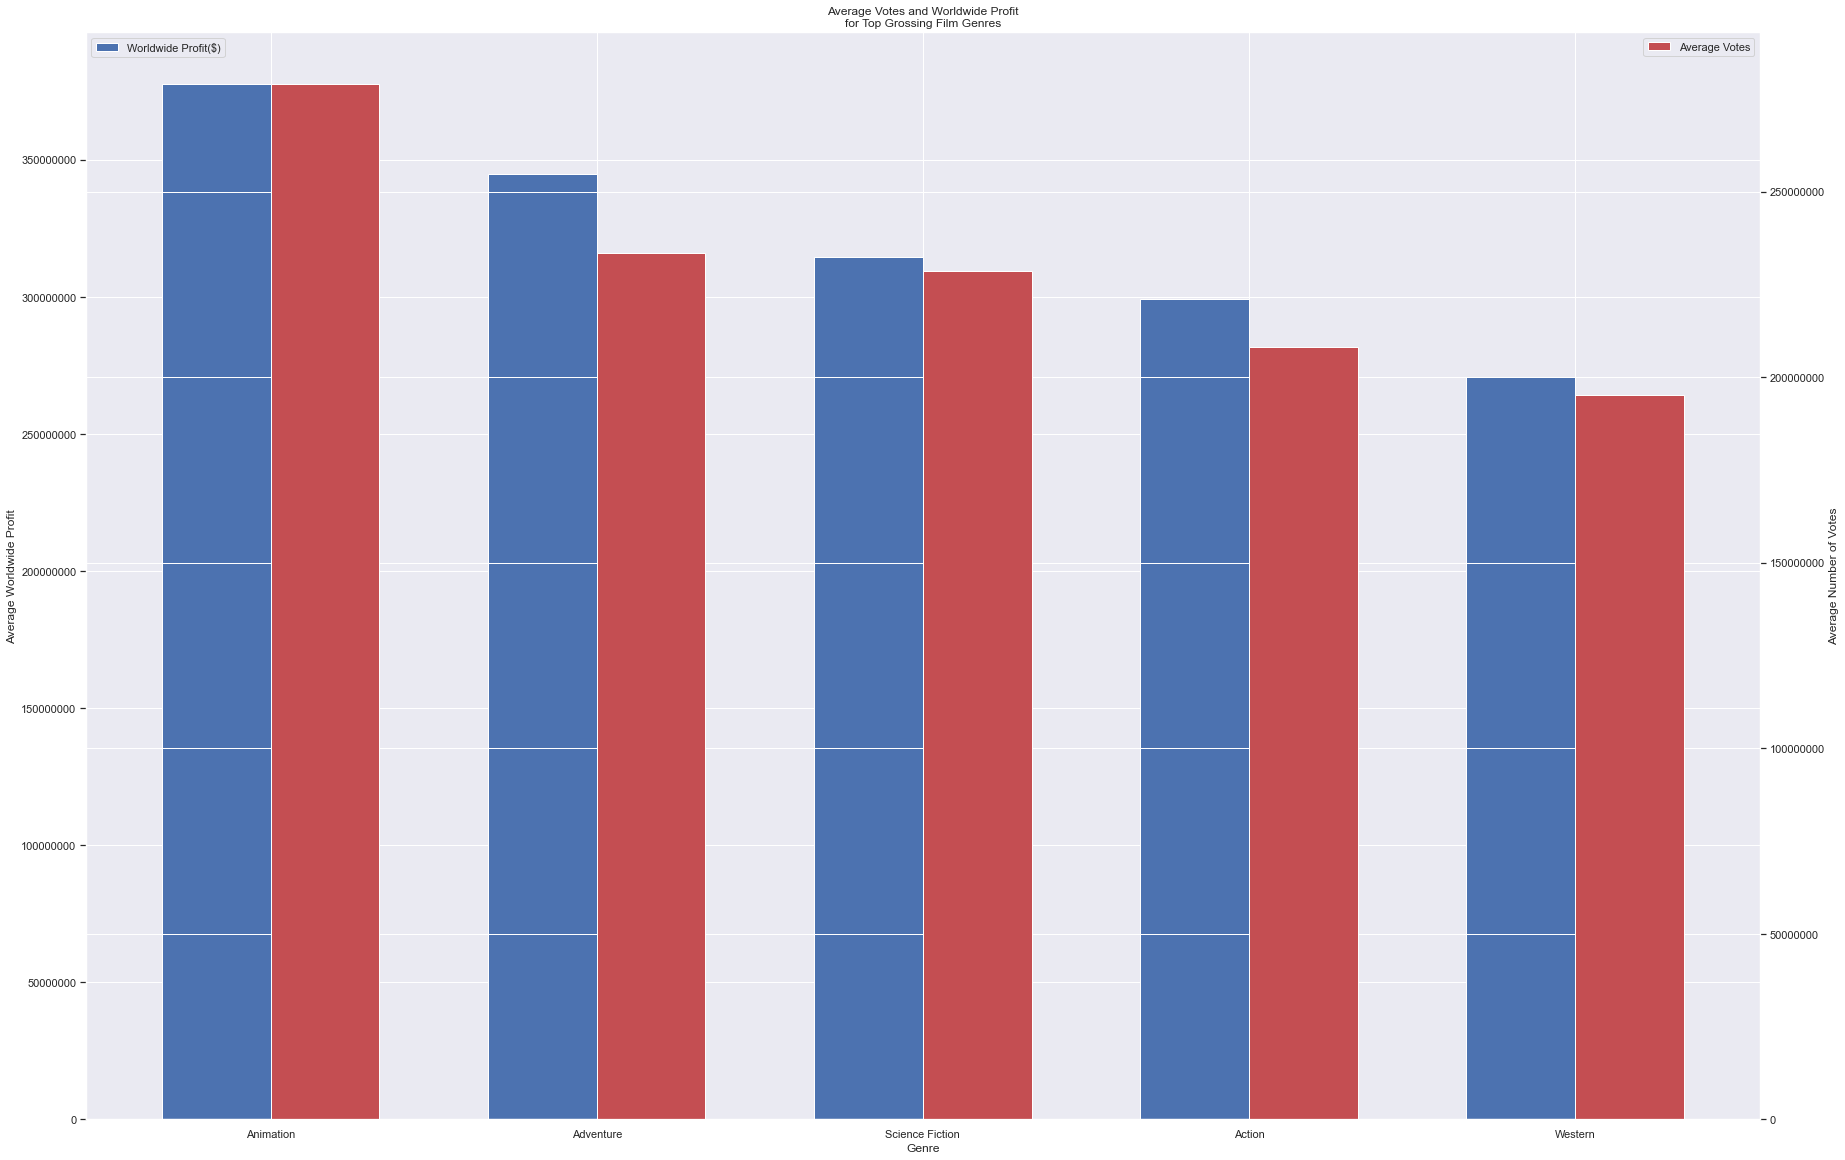

In [129]:
topfivegenresbywwgross = sortgenres.sort_values('worldwide_gross', ascending=False).head()
profitaverage = topfivegenresbywwgross['worldwide_gross'] - topfivegenresbywwgross['production_budget']
runtimeinfo = topfivegenresbywwgross['worldwide_gross']
numvoteinfo = profitaverage
indices = range(len(topfivegenresbywwgross))
genreinfo = topfivegenresbywwgross.index
# Calculate optimal width
width = np.min(np.diff(indices))/3.

fig, ax1 = plt.subplots(figsize=(30,20))
ax1.bar(indices-width/2.,runtimeinfo,width,color='b', label='Worldwide Profit($)')
ax2 = ax1.twinx()
ax2.bar(indices+width/2.,numvoteinfo,width,color='r', label='Average Votes')
# tiks = ax.get_xticks()
ax1.axes.set_xticklabels(genreinfo)
ax1.set_xlabel('Genre')
ax1.set_ylabel('Average Worldwide Profit')
ax2.set_ylabel('Average Number of Votes')
ax1.set_xticks(indices)
ax1.set_title('Average Votes and Worldwide Profit\nfor Top Grossing Film Genres')
ax1.legend(loc=2)
ax2.legend(loc=0)
ax1.ticklabel_format(style='plain', axis='y')
ax2.ticklabel_format(style='plain', axis='y')
plt.show()

In [130]:
sortsecondgenres = final_df.groupby('genre_1').mean().sort_values('worldwide_gross', ascending=False).head()
sortsecondgenres

,production_budget,domestic_gross,worldwide_gross,runtime_minutes,averagerating,numvotes,release_year,net_profits,profit_to_budget_ratio
genre_1,,,,,,,,,
Adventure,128036363.63636,158095695.64545,449909107.30000,114.50459,6.54954,246342.76147,2014.19091,321872743.66364,2.48863
Animation,85450000.00000,127508710.43333,327341345.86667,95.36667,6.54333,106544.43333,2015.33333,241891345.86667,4.66214
Family,97600000.00000,118312409.40000,325950688.02222,101.90698,6.39773,110123.00000,2013.35556,228350688.02222,2.64411
Action,93273529.41176,104963224.82353,292775293.77941,114.52239,6.57794,214949.42647,2013.50000,199501764.36765,2.11482
Fantasy,87626315.78947,92972316.47368,265292887.15789,114.84211,6.14737,182570.65789,2013.28947,177666571.36842,2.23084


<ipython-input-131-c68cfae19fbf>:14: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax1.axes.set_xticklabels(genreinfo)


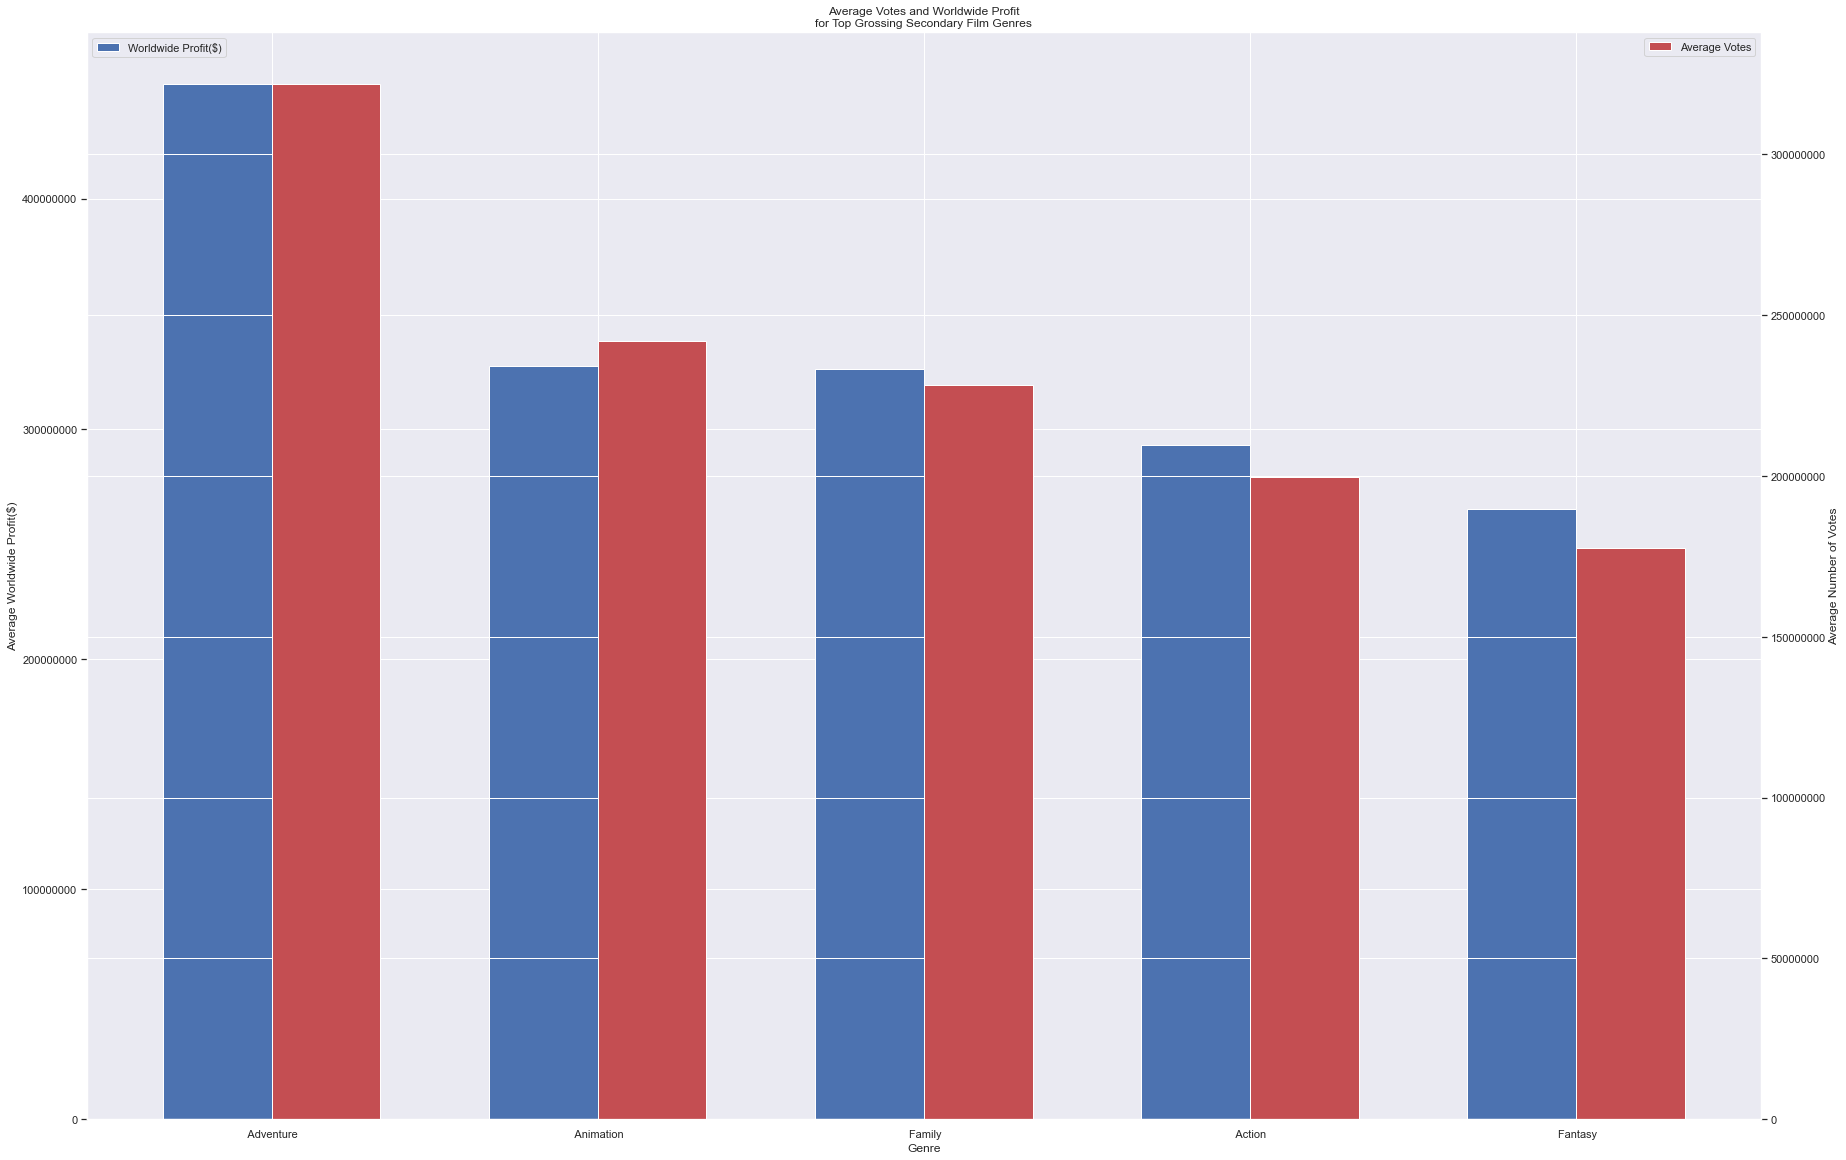

In [131]:
profitaverage = sortsecondgenres['worldwide_gross'] - sortsecondgenres['production_budget']
runtimeinfo = sortsecondgenres['worldwide_gross']
numvoteinfo = profitaverage
indices = range(len(sortsecondgenres))
genreinfo = sortsecondgenres.index
# Calculate optimal width
width = np.min(np.diff(indices))/3.

fig, ax1 = plt.subplots(figsize=(30,20))
ax1.bar(indices-width/2.,runtimeinfo,width,color='b', label='Worldwide Profit($)')
ax2 = ax1.twinx()
ax2.bar(indices+width/2.,numvoteinfo,width,color='r', label='Average Votes')
# tiks = ax.get_xticks()
ax1.axes.set_xticklabels(genreinfo)
ax1.set_xlabel('Genre')
ax1.set_ylabel('Average Worldwide Profit($)')
ax2.set_ylabel('Average Number of Votes')
ax1.set_xticks(indices)
ax1.set_title('Average Votes and Worldwide Profit\nfor Top Grossing Secondary Film Genres')
ax1.legend(loc=2)
ax2.legend(loc=0)
ax1.ticklabel_format(style='plain', axis='y')
ax2.ticklabel_format(style='plain', axis='y')
plt.show()

In [132]:
final_df.head()

,movie,production_budget,domestic_gross,worldwide_gross,genre_ids,release_date_movies,runtime_minutes,averagerating,numvotes,release_month,genre_0,genre_1,release_year,net_profits,profit_to_budget_ratio
0,Avatar,425000000,760507625,2776345279,"[Action, Adventure, Fantasy, Science Fiction]",2009-12-18,93.00000,6.10000,43.00000,12,Action,Adventure,2009,2351345279,5.53258
1,Pirates of the Caribbean: On Stranger Tides,410600000,241063875,1045663875,"[Adventure, Action, Fantasy]",2011-05-20,136.00000,6.60000,447624.00000,05,Adventure,Action,2011,635063875,1.54667
2,Avengers: Age of Ultron,330600000,459005868,1403013963,"[Action, Adventure, Science Fiction]",2015-05-01,141.00000,7.30000,665594.00000,05,Action,Adventure,2015,1072413963,3.24384
3,Avengers: Infinity War,300000000,678815482,2048134200,"[Adventure, Action, Fantasy]",2018-04-27,149.00000,8.50000,670926.00000,04,Adventure,Action,2018,1748134200,5.82711
4,Justice League,300000000,229024295,655945209,"[Action, Adventure, Fantasy, Science Fiction]",2017-11-17,120.00000,6.50000,329135.00000,11,Action,Adventure,2017,355945209,1.18648


In [133]:
#REFERENCE FOR ANNIE - PAULS PERSONAL CODE FOR CHARTS IS BELOW

In [134]:
month_medians = final_df.groupby('release_month').median()

In [135]:
month_medians.reset_index(drop=False, inplace=True)

month_medians

,release_month,production_budget,domestic_gross,worldwide_gross,runtime_minutes,averagerating,numvotes,release_year,net_profits,profit_to_budget_ratio
0,01,30000000.00000,32755002.50000,64645186.00000,102.00000,5.90000,50253.50000,2014.00000,35893707.50000,1.41226
1,02,32500000.00000,39123589.00000,82497035.00000,105.00000,6.20000,81656.00000,2014.00000,37445534.00000,1.68870
2,03,35000000.00000,37537553.50000,73746965.00000,106.50000,6.40000,85518.50000,2014.00000,28604314.00000,1.29875
3,04,26000000.00000,35988974.50000,59708737.00000,103.00000,6.40000,53765.00000,2014.00000,34873948.00000,1.71618
4,05,35500000.00000,55035677.50000,131315260.50000,112.00000,6.50000,119506.00000,2013.00000,82052212.00000,1.88765
5,06,40000000.00000,47142809.00000,92564319.50000,108.00000,6.45000,109417.00000,2014.00000,50214367.50000,1.59177
6,07,35000000.00000,55802754.00000,127234389.00000,104.00000,6.45000,99140.50000,2014.00000,85008658.00000,2.24420
7,08,28500000.00000,31171484.50000,69193426.00000,104.50000,6.40000,78580.00000,2014.00000,35682206.00000,1.30418
8,09,25000000.00000,28793274.50000,49233164.50000,106.00000,6.75000,62822.50000,2013.00000,27816484.00000,1.51879
9,10,20000000.00000,18318587.50000,38712687.00000,107.00000,6.60000,59750.00000,2014.00000,18284481.50000,1.23320


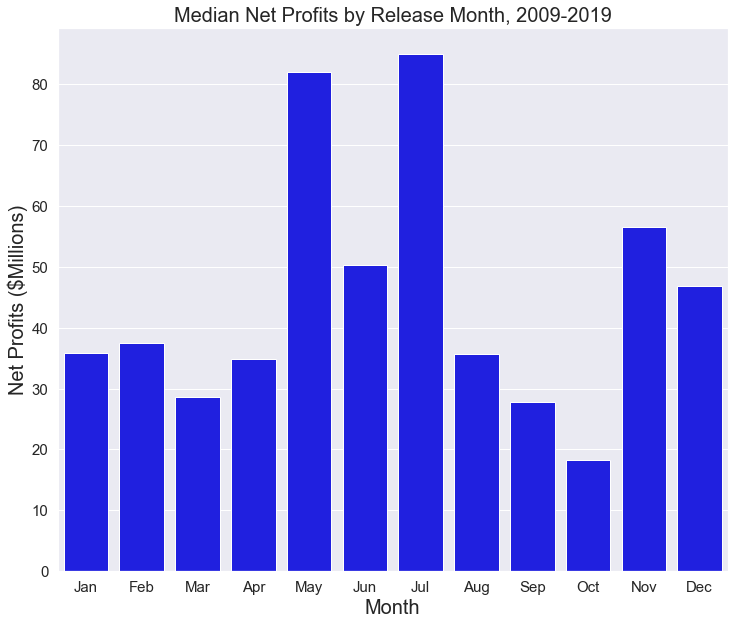

In [136]:
fig, ax = plt.subplots(figsize = (12 , 10))

y = month_medians['net_profits'] / 1000000
ticklabels = ['Jan', 'Feb', 'Mar', 'Apr', 'May', 'Jun', 'Jul', 'Aug', 'Sep', 'Oct', 'Nov', 'Dec']

fig = sns.barplot(data = month_medians,
                  x = 'release_month',
                  y = y,
                  color = 'blue',)

plt.xlabel('Month', size=20)
ax.set_xticklabels(ticklabels, size=15)
plt.ylabel('Net Profits ($Millions)', size=20)
plt.yticks(fontsize=15)
plt.title('Median Net Profits by Release Month, 2009-2019', size=20)
plt.show(fig);

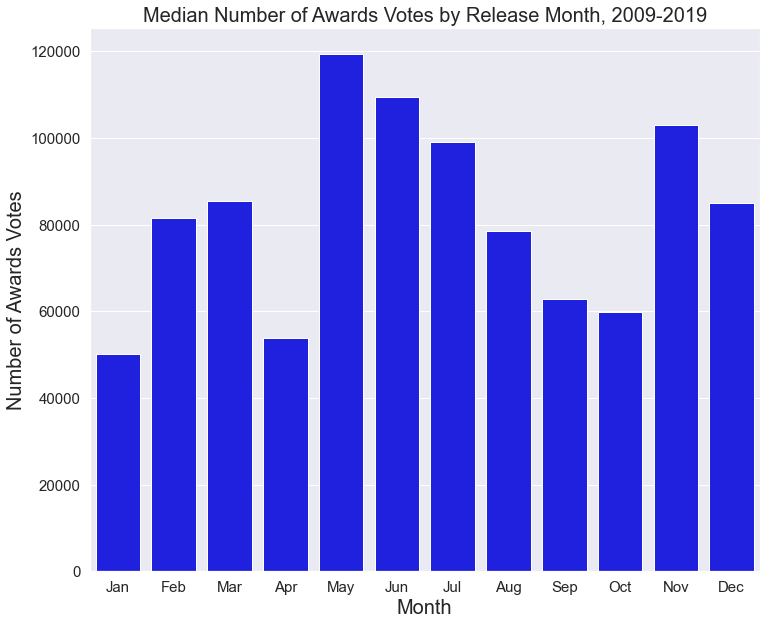

In [137]:
fig, ax = plt.subplots(figsize = (12 , 10))

ticklabels = ['Jan', 'Feb', 'Mar', 'Apr', 'May', 'Jun', 'Jul', 'Aug', 'Sep', 'Oct', 'Nov', 'Dec']

fig = sns.barplot(data = month_medians,
                  x = 'release_month',
                  y = 'numvotes',
                  color = 'blue',)

plt.xlabel('Month', size=20)
ax.set_xticklabels(ticklabels, size=15)
plt.ylabel('Number of Awards Votes', size=20)
plt.yticks(fontsize=15)
plt.title('Median Number of Awards Votes by Release Month, 2009-2019', size=20)
plt.show(fig);

In [138]:
top_ratio_all = final_df.sort_values(by='profit_to_budget_ratio', ascending=False).head(10)

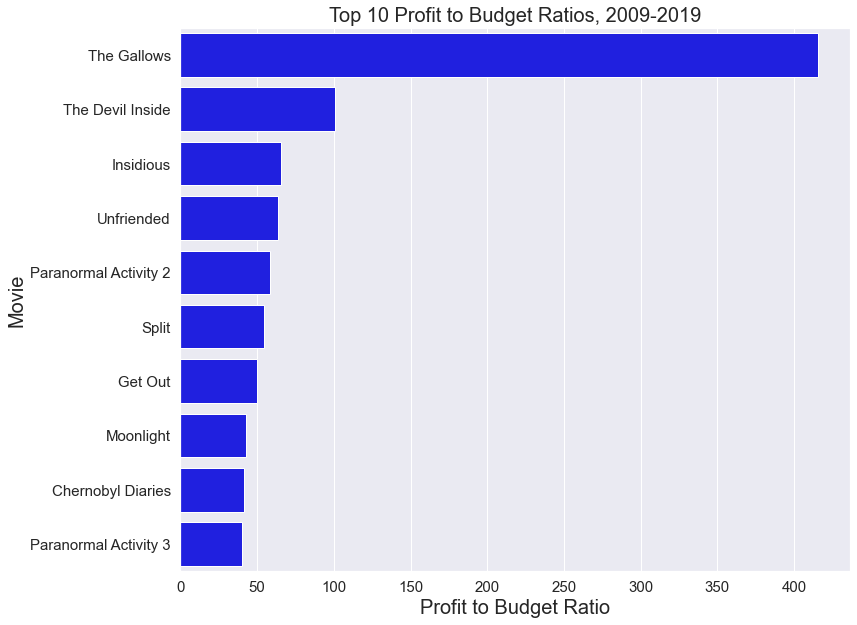

In [139]:
fig, ax = plt.subplots(figsize = (12 , 10))

fig = sns.barplot(data = top_ratio_all,
                  x = 'profit_to_budget_ratio',
                  y = 'movie',
                  color = 'blue',)

plt.xlabel('Profit to Budget Ratio', size=20)
plt.xticks(fontsize=15)
plt.ylabel('Movie', size=20)
plt.yticks(fontsize=15)
plt.title('Top 10 Profit to Budget Ratios, 2009-2019', size=20)
plt.show(fig);